# **Appendix/Code**

In [1]:
!pip install celluloid

In [2]:
# imports
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import auc
from sklearn.neighbors import NearestNeighbors
from scipy.integrate import simpson
from celluloid import Camera
from IPython.display import display, Image, HTML
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import datasets to dfs
games_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/games.csv')
players_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/players.csv')
plays_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
tackles_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')
tracking_week_1_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv')
tracking_week_2_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_2.csv')
tracking_week_3_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_3.csv')
tracking_week_4_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_4.csv')
tracking_week_5_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_5.csv')
tracking_week_6_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_6.csv')
tracking_week_7_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_7.csv')
tracking_week_8_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_8.csv')
tracking_week_9_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_9.csv')

In [4]:
def round_time_to_microsecond(dt_field):

    new_micro = round(dt_field.microsecond, -5)
    new_dt = dt_field.replace(microsecond = new_micro)

    return new_dt

def distance(x1, y1, x2, y2):

    return np.sqrt( ((x2 - x1) ** 2) + ((y2 - y1) ** 2) )

def get_distance_from_ball(play_df):

    ball_df = play_df[play_df['club'] == 'football']
    frames = list(set(ball_df['frameId']))
    players = list(set(play_df['displayName']))

    ball_loc_dict = { ball_df['frameId'].iloc[i] : ( ball_df['x'].iloc[i], ball_df['y'].iloc[i] ) for i in range(len(ball_df)) }

    dist_to_ball_arr = []

    for i in range(len(play_df)):

        ball_x_y = ball_loc_dict[ play_df['frameId'].iloc[i] ]
        player_x = play_df['x'].iloc[i]
        player_y = play_df['y'].iloc[i]

        dist_to_ball_arr.append( distance(ball_x_y[0], ball_x_y[1], player_x, player_y) )

    return dist_to_ball_arr

def assign_clusters(single_frame_of_play_df):

    X = np.array(single_frame_of_play_df[['x', 'y']])
    clustering = MeanShift().fit(X)

    return clustering.labels_

def animate_play(single_play_df, plays_df, tackles_df):

    single_play_df = single_play_df.merge(right = plays_df, how = 'left', on = ['gameId', 'playId'])
    single_play_df = single_play_df.merge(right = tackles_df, how = 'left', on = ['gameId', 'playId', 'nflId'])

    if (len(single_play_df[single_play_df['tackle'] == 1]['nflId']) > 0):
        tackler_id = single_play_df[single_play_df['tackle'] == 1]['nflId'].iloc[0]

    frames = list(set(single_play_df['frameId']))

    fig, ax = plt.subplots(1, 1, figsize = (18, 9))
    camera = Camera(fig)

    for frame in frames:

        play_frame = single_play_df[(single_play_df['frameId'] == frame)]
        play_frame['cluster'] = assign_clusters(play_frame)
        play_frame_teams = play_frame[play_frame['club'] != 'football']
        play_frame_offense = play_frame_teams[play_frame_teams['club'] == play_frame_teams['possessionTeam']]
        play_frame_defense = play_frame_teams[play_frame_teams['club'] != play_frame_teams['possessionTeam']]
        if (len(single_play_df[single_play_df['tackle'] == 1]['nflId']) > 0):
            play_tackler_frame = play_frame[(play_frame['frameId'] == frame) & (play_frame['nflId'] == tackler_id)]
        play_ball_frame = play_frame[(play_frame['frameId'] == frame) & (play_frame['club'] == 'football')]

        ax.scatter(play_frame_offense['x'], play_frame_offense['y'], color = 'blue', marker = '.', label = 'Offense')
        ax.scatter(play_frame_defense['x'], play_frame_defense['y'], color = 'red', marker = 'x', label = 'Defense')
        if (len(single_play_df[single_play_df['tackle'] == 1]['nflId']) > 0):
            ax.scatter(play_tackler_frame['x'], play_tackler_frame['y'], color = 'red', marker = 'D', label = 'Defense')
        ax.scatter(play_ball_frame['x'], play_ball_frame['y'], color = 'green', label = 'Ball')
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 53.5)
        ax.set_title('Play Movement')

        for i in range(len(play_frame_offense['cluster'])):

            plt.annotate(str(play_frame_offense['cluster'].iloc[i]), ( play_frame_offense['x'].iloc[i], play_frame_offense['y'].iloc[i]))

        for i in range(len(play_frame_defense['cluster'])):

            plt.annotate(str(play_frame_defense['cluster'].iloc[i]), ( play_frame_defense['x'].iloc[i], play_frame_defense['y'].iloc[i]))

        for i in range(len(play_ball_frame['cluster'])):

            plt.annotate(str(play_ball_frame['cluster'].iloc[i]), ( play_ball_frame['x'].iloc[i], play_ball_frame['y'].iloc[i]))

        camera.snap()

    anim = camera.animate()
    return HTML(anim.to_jshtml())

def ball_cluster_concentration(single_play_df, plays_df):

    new_single_play = copy.deepcopy(single_play_df)
    new_single_play = new_single_play.merge(right = plays_df, how = 'left', on = ['gameId', 'playId'])
    frames = list(set(new_single_play['frameId']))
    ball_cluster_count_offense_arr = []
    ball_cluster_count_defense_arr = []
    ball_cluster_label_arr = []

    for frame in frames:

        play_frame = new_single_play[(new_single_play['frameId'] == frame)]
        play_frame['cluster'] = assign_clusters(play_frame)
        play_frame_teams = play_frame[play_frame['club'] != 'football']
        play_frame_offense = play_frame_teams[play_frame_teams['club'] == play_frame_teams['possessionTeam']]
        play_frame_defense = play_frame_teams[play_frame_teams['club'] != play_frame_teams['possessionTeam']]
        play_ball_frame = play_frame[play_frame['club'] == 'football']

        ball_cluster_label = play_ball_frame['cluster'].iloc[0]
        ball_cluster_label_arr.append(ball_cluster_label)
        ball_cluster_count_offense = len(play_frame_offense['cluster'][play_frame_offense['cluster'] == ball_cluster_label])
        ball_cluster_count_defense = len(play_frame_defense['cluster'][play_frame_defense['cluster'] == ball_cluster_label])
        ball_cluster_count_offense_arr.append(ball_cluster_count_offense)
        ball_cluster_count_defense_arr.append(ball_cluster_count_defense)

    ball_cluster_count_df = pd.DataFrame()
    ball_cluster_count_df['frameId'] = frames
    ball_cluster_count_df['frameTime'] = sorted(list(set(new_single_play[new_single_play['displayName'] != 'football']['timeFormatted'])))
    ball_cluster_count_df['offenseCount'] = ball_cluster_count_offense_arr
    ball_cluster_count_df['defenseCount'] = ball_cluster_count_defense_arr
    ball_cluster_count_df['ballCluster'] = ball_cluster_label_arr
    ball_cluster_count_df['totalPlayerCount'] = [len(set(play_frame_teams['displayName'].dropna()))] * len(frames)
    ball_cluster_count_df['offenseRatioInCluster'] = ball_cluster_count_df['offenseCount'] / (ball_cluster_count_df['offenseCount'] + ball_cluster_count_df['defenseCount'])
    ball_cluster_count_df['defenseRatioInCluster'] = ball_cluster_count_df['defenseCount'] / (ball_cluster_count_df['offenseCount'] + ball_cluster_count_df['defenseCount'])
    ball_cluster_count_df['offenseRatioTotal'] = ball_cluster_count_df['offenseCount'] / (ball_cluster_count_df['totalPlayerCount'])
    ball_cluster_count_df['defenseRatioTotal'] = ball_cluster_count_df['defenseCount'] / (ball_cluster_count_df['totalPlayerCount'])
    ball_cluster_count_df['totalRatioTotal'] = (ball_cluster_count_df['offenseCount'] + ball_cluster_count_df['defenseCount']) / (ball_cluster_count_df['totalPlayerCount'])
    ball_df_frame_event = new_single_play[new_single_play['club'] == 'football'][['frameId', 'event']]
    ball_cluster_count_df = ball_cluster_count_df.merge(right = ball_df_frame_event, how = 'left', on = ['frameId'])

    return ball_cluster_count_df

def tackler_cluster_concentration(single_play_df, plays_df, tackles_df):

    new_single_play = copy.deepcopy(single_play_df)
    new_single_play = new_single_play.merge(right = plays_df, how = 'left', on = ['gameId', 'playId'])
    tackles_df1 = tackles_df[tackles_df['tackle'] == 1]
    new_single_play = new_single_play.merge(right = tackles_df1, how = 'left', on = ['gameId', 'playId', 'nflId'])

    # if no tackle is listed return 0 for all values
    if ( (len(new_single_play[new_single_play['tackle'] == 1]['nflId']) == 0) ):
        tackler_cluster_count_df = pd.DataFrame()
        tackler_cluster_count_df['frameId'] = [0]
        tackler_cluster_count_df['frameTime'] = [0]
        tackler_cluster_count_df['friendlyCount'] = [0]
        tackler_cluster_count_df['enemyCount'] = [0]
        tackler_cluster_count_df['tacklerCluster'] = [0]
        tackler_cluster_count_df['totalPlayerCount'] = [0]
        tackler_cluster_count_df['friendlyRatioInCluster'] = [0]
        tackler_cluster_count_df['enemyRatioInCluster'] = [0]
        tackler_cluster_count_df['friendlyRatioTotal'] = [0]
        tackler_cluster_count_df['enemyRatioTotal'] = [0]
        tackler_cluster_count_df['totalRatioTotal'] = [0]

        return tackler_cluster_count_df

    if (len(new_single_play[new_single_play['tackle'] == 1]['nflId']) > 0):

        tackler_id = new_single_play[new_single_play['tackle'] == 1]['nflId'].iloc[0]
        frames = list(set(new_single_play['frameId']))
        tackler_cluster_count_offense_arr = []
        tackler_cluster_count_defense_arr = []
        tackler_cluster_label_arr = []

        for frame in frames:

            play_frame = new_single_play[(new_single_play['frameId'] == frame)]
            play_frame['cluster'] = assign_clusters(play_frame)
            play_frame_teams = play_frame[play_frame['club'] != 'football']
            play_frame_offense = play_frame_teams[play_frame_teams['club'] == play_frame_teams['possessionTeam']]
            play_frame_defense = play_frame_teams[play_frame_teams['club'] != play_frame_teams['possessionTeam']]
            play_tackler_frame = play_frame[play_frame['nflId'] == tackler_id]

            tackler_cluster_label = play_tackler_frame['cluster'].iloc[0]
            tackler_cluster_label_arr.append(tackler_cluster_label)

            tackler_cluster_count_offense = len(play_frame_offense['cluster'][play_frame_offense['cluster'] == tackler_cluster_label])
            tackler_cluster_count_offense_arr.append(tackler_cluster_count_offense)
            tackler_cluster_count_defense = len(play_frame_defense['cluster'][play_frame_defense['cluster'] == tackler_cluster_label])
            tackler_cluster_count_defense_arr.append(tackler_cluster_count_defense)

    tackler_cluster_count_df = pd.DataFrame()
    tackler_cluster_count_df['frameId'] = frames
    tackler_cluster_count_df['frameTime'] = sorted(list(set(single_play_df[single_play_df['displayName'] != 'football']['timeFormatted'])))
    tackler_cluster_count_df['offenseCount'] = tackler_cluster_count_offense_arr
    tackler_cluster_count_df['defenseCount'] = tackler_cluster_count_defense_arr
    tackler_cluster_count_df['tacklerCluster'] = tackler_cluster_label_arr
    tackler_cluster_count_df['totalPlayerCount'] = [len(set(play_frame_teams['displayName'].dropna()))] * len(frames)
    tackler_cluster_count_df['offenseRatioInCluster'] = tackler_cluster_count_df['offenseCount'] / (tackler_cluster_count_df['offenseCount'] + tackler_cluster_count_df['defenseCount'])
    tackler_cluster_count_df['defenseRatioInCluster'] = tackler_cluster_count_df['defenseCount'] / (tackler_cluster_count_df['offenseCount'] + tackler_cluster_count_df['defenseCount'])
    tackler_cluster_count_df['offenseRatioTotal'] = tackler_cluster_count_df['offenseCount'] / (tackler_cluster_count_df['totalPlayerCount'])
    tackler_cluster_count_df['defenseRatioTotal'] = tackler_cluster_count_df['defenseCount'] / (tackler_cluster_count_df['totalPlayerCount'])
    tackler_cluster_count_df['totalRatioTotal'] = (tackler_cluster_count_df['offenseCount'] + tackler_cluster_count_df['defenseCount']) / (tackler_cluster_count_df['totalPlayerCount'])
    tackler_df_frame_event = single_play_df[single_play_df['nflId'] == tackler_id][['frameId', 'event']]
    tackler_cluster_count_df = tackler_cluster_count_df.merge(right = tackler_df_frame_event, how = 'left', on = ['frameId'])

    return tackler_cluster_count_df

def create_cluster_metrics_per_play(tracking_df, plays_df, tackles_df):

    game_ids = sorted(list(set(tracking_df['gameId'])))
    game_id_arr = []
    play_id_arr = []
    ball_cluster_offense_ratio_auc_arr = []
    ball_cluster_defense_ratio_auc_arr = []
    ball_cluster_offense_total_auc_arr = []
    ball_cluster_defense_total_auc_arr = []
    ball_cluster_total_ratio = []
    tackler_cluster_offense_ratio_auc_arr = []
    tackler_cluster_defense_ratio_auc_arr = []
    tackler_cluster_offense_total_auc_arr = []
    tackler_cluster_defense_total_auc_arr = []
    tackler_cluster_total_ratio = []

    for game_id in tqdm(game_ids):

        game_df = tracking_df[tracking_df['gameId'] == game_id]

        play_ids = sorted(list(set(game_df['playId'])))

        for play_id in play_ids:

            play_df = game_df[game_df['playId'] == play_id]
            play_id_arr.append(play_id)
            game_id_arr.append(game_id)

            ball_cluster_stats = ball_cluster_concentration(play_df, plays_df)
            tackler_cluster_stats_df = tackler_cluster_concentration(play_df, plays_df, tackles_df)

            ball_cluster_offense_ratio_auc_arr.append(np.trapz(ball_cluster_stats['offenseRatioInCluster']))
            ball_cluster_defense_ratio_auc_arr.append(np.trapz(ball_cluster_stats['defenseRatioInCluster']))
            ball_cluster_offense_total_auc_arr.append(np.trapz(ball_cluster_stats['offenseRatioTotal']))
            ball_cluster_defense_total_auc_arr.append(np.trapz(ball_cluster_stats['defenseRatioTotal']))
            ball_cluster_total_ratio.append(np.trapz(ball_cluster_stats['totalRatioTotal']))

            # verify if a tackle occurred
            play_df_copy = copy.deepcopy(play_df)
            play_df_copy = play_df_copy.merge(right = plays_df, how = 'left', on = ['gameId', 'playId'])
            tackles_df1 = tackles_df[tackles_df['tackle'] == 1]
            play_df_copy = play_df_copy.merge(right = tackles_df1, how = 'left', on = ['gameId', 'playId', 'nflId'])

            if (len(play_df_copy[play_df_copy['tackle'] == 1]['nflId']) > 0):
                tackler_cluster_offense_ratio_auc_arr.append(np.trapz(tackler_cluster_stats_df['offenseRatioInCluster']))
                tackler_cluster_defense_ratio_auc_arr.append(np.trapz(tackler_cluster_stats_df['defenseRatioInCluster']))
                tackler_cluster_offense_total_auc_arr.append(np.trapz(tackler_cluster_stats_df['offenseRatioTotal']))
                tackler_cluster_defense_total_auc_arr.append(np.trapz(tackler_cluster_stats_df['defenseRatioTotal']))
                tackler_cluster_total_ratio.append(np.trapz(tackler_cluster_stats_df['totalRatioTotal']))

            elif (len(play_df_copy[play_df_copy['tackle'] == 1]['nflId']) == 0):
                tackler_cluster_offense_ratio_auc_arr.append(0)
                tackler_cluster_defense_ratio_auc_arr.append(0)
                tackler_cluster_offense_total_auc_arr.append(0)
                tackler_cluster_defense_total_auc_arr.append(0)
                tackler_cluster_total_ratio.append(0)

    cluster_stats_df = pd.DataFrame()
    cluster_stats_df['gameId'] = game_id_arr
    cluster_stats_df['playId'] = play_id_arr
    cluster_stats_df['ballClusterOffenseAuc'] = ball_cluster_offense_ratio_auc_arr
    cluster_stats_df['ballClusterDefenseAuc'] = ball_cluster_defense_ratio_auc_arr
    cluster_stats_df['ballTotalOffenseAuc'] = ball_cluster_offense_total_auc_arr
    cluster_stats_df['ballTotalDefenseAuc'] = ball_cluster_defense_total_auc_arr
    cluster_stats_df['ballTotalAuc'] = ball_cluster_total_ratio
    cluster_stats_df['tackleClusterOffenseAuc'] = tackler_cluster_offense_ratio_auc_arr
    cluster_stats_df['tackleClusterDefenseAuc'] = tackler_cluster_defense_ratio_auc_arr
    cluster_stats_df['tackleTotalOffenseAuc'] = tackler_cluster_offense_total_auc_arr
    cluster_stats_df['tackleTotalDefenseAuc'] = tackler_cluster_defense_total_auc_arr
    cluster_stats_df['tackleTotalAuc'] = tackler_cluster_total_ratio

    return cluster_stats_df

def snap_to_tackle_time(single_play_df):

    #returns time in seconds
    tackle_time = single_play_df[single_play_df['event'] == 'tackle']['timeFormatted'].iloc[0]
    start_time = max(single_play_df[single_play_df['frameId'] == 1]['timeFormatted'])

    time_to_tackle = (tackle_time - start_time)

    return time_to_tackle.value / 1e9

def create_stt_metrics(tracking_df):

    game_ids = sorted(list(set(tracking_df['gameId'])))
    game_id_arr = []
    play_id_arr = []
    stt_metric_arr = []

    for game_id in game_ids:

        game_df = tracking_df[tracking_df['gameId'] == game_id]
        play_ids = sorted(list(set(game_df['playId'])))

        for play_id in play_ids:

            play_df = game_df[game_df['playId'] == play_id]
            game_id_arr.append(game_id)
            play_id_arr.append(play_id)
            # if there is no 'tackle' event for a play return nothing
            try:
                stt_metric_arr.append(snap_to_tackle_time(play_df))
            except:
                stt_metric_arr.append(None)

    sst_metric_df = pd.DataFrame()
    sst_metric_df['gameId'] = game_id_arr
    sst_metric_df['playId'] = play_id_arr
    sst_metric_df['sttTime'] = stt_metric_arr

    return sst_metric_df

def get_weight_each_side(single_play_df, players_df, plays_df):

    new_single_play = copy.deepcopy(single_play_df)
    new_single_play = new_single_play.merge(right = players_df, how = 'left', on = 'nflId')
    new_single_play = new_single_play.merge(right = plays_df, how = 'left', on = ['gameId', 'playId'])

    play_df_teams = new_single_play[new_single_play['club'] != 'football']
    play_df_offense = play_df_teams[play_df_teams['club'] == play_df_teams['possessionTeam']]
    play_df_defense = play_df_teams[play_df_teams['club'] != play_df_teams['possessionTeam']]

    offense_weight = sum(play_df_offense[play_df_offense['frameId'] == 1]['weight'])
    defense_weight = sum(play_df_defense[play_df_defense['frameId'] == 1]['weight'])

    return offense_weight, defense_weight

def create_weight_metrics(tracking_df, players_df, plays_df):

    game_ids = sorted(list(set(tracking_df['gameId'])))
    game_id_arr = []
    play_id_arr = []
    offense_weight_metric_arr = []
    defense_weight_metric_arr = []

    for game_id in game_ids:

        game_df = tracking_df[tracking_df['gameId'] == game_id]
        play_ids = sorted(list(set(game_df['playId'])))

        for play_id in play_ids:

            play_df = game_df[game_df['playId'] == play_id]
            game_id_arr.append(game_id)
            play_id_arr.append(play_id)
            offense_weight, defense_weight = get_weight_each_side(play_df, players_df, plays_df)
            offense_weight_metric_arr.append(offense_weight)
            defense_weight_metric_arr.append(defense_weight)

    weight_metric_df = pd.DataFrame()
    weight_metric_df['gameId'] = game_id_arr
    weight_metric_df['playId'] = play_id_arr
    weight_metric_df['offenseWeight'] = offense_weight_metric_arr
    weight_metric_df['defenseWeight'] = defense_weight_metric_arr
    weight_metric_df['weightDelta'] = weight_metric_df['offenseWeight'] - weight_metric_df['defenseWeight']

    return weight_metric_df

def speed_tackler_to_ball_carrier(single_play_df, tackles_df):

    #returns time in seconds
    tackle_time = single_play_df[single_play_df['event'] == 'tackle']['timeFormatted'].iloc[0]
    start_time = max(single_play_df[single_play_df['frameId'] == 1]['timeFormatted'])

    new_single_play = copy.deepcopy(single_play_df)
    new_single_play = new_single_play.merge(right = tackles_df, how = 'left', on = ['gameId', 'playId', 'nflId'])
    tackler_id = new_single_play[new_single_play['tackle'] == 1]['nflId'].iloc[0]

    tackler_play_df = single_play_df[single_play_df['nflId'] == tackler_id]
    tackler_play_df = tackler_play_df[tackler_play_df['timeFormatted'] <= tackle_time]

    avg_accel = np.mean(tackler_play_df['a'])
    avg_speed = np.mean(tackler_play_df['s'])

    return avg_accel, avg_speed

def create_speed_accel_metrics(tracking_df, tackles_df):

    game_ids = sorted(list(set(tracking_df['gameId'])))
    game_id_arr = []
    play_id_arr = []
    accel_metric_arr = []
    speed_metric_arr = []

    for game_id in game_ids:

        game_df = tracking_df[tracking_df['gameId'] == game_id]
        play_ids = sorted(list(set(game_df['playId'])))

        for play_id in play_ids:

            play_df = game_df[game_df['playId'] == play_id]
            game_id_arr.append(game_id)
            play_id_arr.append(play_id)
            #if no tackle occurs append none
            try:
                avg_accel, avg_speed = speed_tackler_to_ball_carrier(play_df, tackles_df)
                accel_metric_arr.append(avg_accel)
                speed_metric_arr.append(avg_speed)
            except:
                accel_metric_arr.append(None)
                speed_metric_arr.append(None)

    weight_metric_df = pd.DataFrame()
    weight_metric_df['gameId'] = game_id_arr
    weight_metric_df['playId'] = play_id_arr
    weight_metric_df['avgTacklerAccel'] = accel_metric_arr
    weight_metric_df['avgTacklerSpeed'] = speed_metric_arr

    return weight_metric_df

def create_features_week_truncated(tracking_df, plays_df, players_df, tackles_df, csv_name):

    game_ids = sorted(list(set(tracking_df['gameId'])))

    for i in range(0, len(game_ids), 3):

        trimmed_game_ids = game_ids[i : i + 3]
        tracking_df_trimmed = tracking_df[tracking_df['gameId'].isin(trimmed_game_ids)]

        stt_metrics_week = create_stt_metrics(tracking_df_trimmed)
        weight_metrics_week = create_weight_metrics(tracking_df_trimmed, players_df, plays_df)
        speed_accel_metrics_week = create_speed_accel_metrics(tracking_df_trimmed, tackles_df)

        combined_df = stt_metrics_week.merge(right = weight_metrics_week, how = 'left', on = ['gameId', 'playId'])
        combined_df = combined_df.merge(right = speed_accel_metrics_week, how = 'left', on = ['gameId', 'playId'])

        csv_name_new = str(i) + '_' + str(i + 2) + '_' + csv_name
        combined_df.to_csv(r'D:\KaggleCompetitions\NFL_2024\nfl-big-data-bowl-2024\features\\' + str(csv_name_new), index = False)

def create_features_week(tracking_df, plays_df, players_df, tackles_df, csv_name):

    game_ids = sorted(list(set(tracking_df['gameId'])))

    stt_metrics_week = create_stt_metrics(tracking_df)
    weight_metrics_week = create_weight_metrics(tracking_df, players_df, plays_df)
    speed_accel_metrics_week = create_speed_accel_metrics(tracking_df, tackles_df)

    combined_df = stt_metrics_week.merge(right = weight_metrics_week, how = 'left', on = ['gameId', 'playId'])
    combined_df = combined_df.merge(right = speed_accel_metrics_week, how = 'left', on = ['gameId', 'playId'])

    combined_df.to_csv(r'D:\KaggleCompetitions\NFL_2024\nfl-big-data-bowl-2024\features\\' + str(csv_name), index = False)

def regress_off_all_formation(X, y, train_size):

    X_form = copy.deepcopy(X)
    y_form = y[y.index.isin(X_form.index)]
    y_form = y_form.dropna()
    X_form = X_form[X_form.index.isin(y_form.index)]
    cols_to_remove = [X_form.columns[i] for i in range(len(X_form.columns)) if 'offenseFormation' in X_form.columns[i]]
    X_form = X_form.drop(cols_to_remove, axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X_form, y_form, train_size = train_size, random_state = 1)

    model = sm.OLS(y_train, X_train.astype(float))
    res = model.fit()
    res_df = pd.DataFrame()
    res_df['variable'] = X_train.columns
    res_df['coef'] = list(res.params)
    res_df['p_vals'] = list(res.pvalues)
    res_df['t_vals'] = list(res.tvalues)

    preds = res.predict(X_test) > 0.5

    return res_df.sort_values(by = ['p_vals'], ascending = True)

def regress_off_formation(X, y, formation_type, train_size):

    X_form = X[X[formation_type] == True]
    y_form = y[y.index.isin(X_form.index)]
    y_form = y_form.dropna()
    X_form = X_form[X_form.index.isin(y_form.index)]
    cols_to_remove = [X_form.columns[i] for i in range(len(X_form.columns)) if 'offenseFormation' in X_form.columns[i]]
    X_form = X_form.drop(cols_to_remove, axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X_form, y_form, train_size = train_size, random_state = 1)

    model = sm.OLS(y_train, X_train.astype(float))
    res = model.fit()
    res_df = pd.DataFrame()
    res_df['variable'] = X_train.columns
    res_df['coev'] = list(res.params)
    res_df['p_vals'] = list(res.pvalues)
    res_df['t_vals'] = list(res.tvalues)

    preds = res.predict(X_test) > 0.5
    print('Accuracy: ' + str(accuracy_score(y_test, preds)))

    return res_df.sort_values(by = ['p_vals'], ascending = True)

def xg_boost(X, y, formation_type, train_size, lr, n_estimators, max_depth):

    X_form = X[X[formation_type] == True]
    y_form = y[y.index.isin(X_form.index)]
    y_form = y_form.dropna()
    y_form = y_form.astype(int)
    X_form = X_form[X_form.index.isin(y_form.index)]
    cols_to_remove = [X_form.columns[i] for i in range(len(X_form.columns)) if 'offenseFormation' in X_form.columns[i]]
    X_form = X_form.drop(cols_to_remove, axis = 1)
    le = LabelEncoder()

    X_train, X_test, y_train, y_test = train_test_split(X_form, y_form, train_size = train_size, random_state = 1)
    y_train = le.fit_transform(y_train)

    model = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = lr, objective = 'binary:logistic')
    scaler = StandardScaler()
    x_trainScaled = scaler.fit_transform(X_train)
    model.fit(x_trainScaled, y_train)
    x_testScaled = scaler.fit_transform(X_test)
    preds = model.predict(x_testScaled)
    preds = le.inverse_transform(preds)

    importance_df = pd.DataFrame()
    importance_df['variable'] = X_train.columns
    importance_df['importance'] = model.feature_importances_

    return (accuracy_score(y_test, preds)), (precision_score(y_test, preds)), (recall_score(y_test, preds))

def dl_model(X, y, formation_type, train_size, epochs, batch_size):

    X_form = X[X[formation_type] == True]
    y_form = y[y.index.isin(X_form.index)]
    y_form = y_form.dropna()
    X_form = X_form[X_form.index.isin(y_form.index)]
    cols_to_remove = [X_form.columns[i] for i in range(len(X_form.columns)) if 'offenseFormation' in X_form.columns[i]]
    X_form = X_form.drop(cols_to_remove, axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X_form, y_form, train_size = train_size, random_state = 1)
    scaler = StandardScaler()
    x_trainScaled = scaler.fit_transform(X_train)
    x_testScaled = scaler.fit_transform(X_test)

    model = Sequential()
    model.add(Dense(128, activation = 'relu', input_dim = x_trainScaled.shape[1]))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])

    hist = model.fit(x_trainScaled, y_train, validation_data = (x_testScaled, y_test), epochs = epochs, batch_size = batch_size, verbose = 0)
    preds = model.predict(x_testScaled) > 0.5

    return (accuracy_score(y_test, preds)), (precision_score(y_test, preds)), (recall_score(y_test, preds))

def rf_regr(X, y, formation_type, train_size, n_estimators, max_depth, max_features):

    X_form = X[X[formation_type] == True]
    y_form = y[y.index.isin(X_form.index)]
    y_form = y_form.dropna()
    X_form = X_form[X_form.index.isin(y_form.index)]
    cols_to_remove = [X_form.columns[i] for i in range(len(X_form.columns)) if 'offenseFormation' in X_form.columns[i]]
    X_form = X_form.drop(cols_to_remove, axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X_form, y_form, train_size = train_size, random_state = 1)
    scaler = StandardScaler()
    x_trainScaled = scaler.fit_transform(X_train)
    x_testScaled = scaler.fit_transform(X_test)

    clf = RandomForestClassifier(n_estimators = 500, max_depth = 4, max_features = 3, random_state = 1).fit(x_trainScaled, y_train)
    rf_pred = clf.predict(x_testScaled)

    importance_df = pd.DataFrame()
    importance_df['variable'] = X_train.columns
    importance_df['importance'] = clf.feature_importances_

    return (accuracy_score(y_test, rf_pred)), (precision_score(y_test, rf_pred)), (recall_score(y_test, rf_pred))

def svm_model(X, y, formation_type, train_size, C):

    X_form = X[X[formation_type] == True]
    y_form = y[y.index.isin(X_form.index)]
    y_form = y_form.dropna()
    X_form = X_form[X_form.index.isin(y_form.index)]
    cols_to_remove = [X_form.columns[i] for i in range(len(X_form.columns)) if 'offenseFormation' in X_form.columns[i]]
    X_form = X_form.drop(cols_to_remove, axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X_form, y_form, train_size = train_size, random_state = 1)
    scaler = StandardScaler()
    x_trainScaled = scaler.fit_transform(X_train)
    x_testScaled = scaler.fit_transform(X_test)

    svm_clf = svm.SVC(C = C, kernel = 'linear', random_state = 1)
    svm_clf.fit(x_trainScaled, y_train)
    svm_pred = svm_clf.predict(x_testScaled)

    importance_df = pd.DataFrame()
    importance_df['variable'] = X_train.columns
    importance_df['coef'] = svm_clf.coef_[0]

    return (accuracy_score(y_test, svm_pred)), (precision_score(y_test, svm_pred)), (recall_score(y_test, svm_pred))

def xg_param_tuning(X, y, formation_type, n_estimators, max_depth):

    lr_arr = np.arange(0.0, 1.05, 0.05)
    train_size_arr = np.arange(0.01, 0.90, 0.05)
    max_acc = 0
    max_lr = 0
    max_train_size = 0

    for lr in (lr_arr):
      for train_size in train_size_arr:

        acc = xg_boost(X, y, formation_type, train_size, lr, n_estimators, max_depth)
        if (acc[0] > max_acc):
            max_acc = acc[0]
            max_lr = lr
            max_train_size = train_size

    return max_lr, max_train_size

def dl_param_tuning(X, y, formation_type, epochs):

    batch_size_arr = np.arange(5, 55, 5)
    train_size_arr = np.arange(0.01, 0.90, 0.05)
    max_acc = 0
    max_bs = 0
    max_train_size = 0

    for batch_size in (batch_size_arr):
      for train_size in train_size_arr:

        acc = dl_model(X, y, formation_type, train_size, epochs, batch_size)
        if (acc[0] > max_acc):
            max_acc = acc[0]
            max_bs = batch_size
            max_train_size = train_size

    return max_bs, max_train_size

def rf_param_tuning(X, y, formation_type):

    train_size_arr = np.arange(0.01, 0.85, 0.05)
    max_acc = 0
    max_train_size = 0

    for train_size in train_size_arr:

      acc = rf_regr(X, y, 'offenseFormation_JUMBO', train_size = train_size, n_estimators = 10, max_depth = 100, max_features = 10)
      if (acc[0] > max_acc):
          max_acc = acc[0]
          max_train_size = train_size

    return max_train_size

def svm_param_tuning(X, y, formation_type):

    C_arr = np.arange(0.01, 1.0, 0.01)
    train_size_arr = np.arange(0.05, 0.90, 0.05)
    max_acc = 0
    max_C = 0
    max_train_size = 0

    for c in (C_arr):
      for train_size in train_size_arr:

        acc = svm_model(X, y, formation_type, train_size, c)
        if (acc[0] > max_acc):
            max_acc = acc[0]
            max_C = c
            max_train_size = train_size

    return max_C, max_train_size

def get_formation_X(X, y, formation_type):

    X_form = X[X[formation_type] == True]
    y_form = y[y.index.isin(X_form.index)]
    y_form = y_form.dropna()
    X_form = X_form[X_form.index.isin(y_form.index)]
    cols_to_remove = [X_form.columns[i] for i in range(len(X_form.columns)) if 'offenseFormation' in X_form.columns[i]]
    X_form = X_form.drop(cols_to_remove, axis = 1)

    return X_form, y_form

def show_ball_cluster_graphs(ball_cluster_df):
    try:
        tackle_frame = cluster_stats[cluster_stats['event'] == 'tackle']['frameId'].iloc[0]
    except:
        tackle_frame = 0

    fig, ax = plt.subplots(2, 2, figsize = (18, 9))
    ax[0][0].plot(cluster_stats['frameId'], cluster_stats['offenseRatioInCluster'], label = 'Offense Cluster Ratio')
    ax[0][0].set_title('Offense Cluster Ratio')
    ax[0][0].set_ylim([0, 1.0])
    ax[0][0].vlines(x = tackle_frame, ymin = 0, ymax = 1.0, color = 'red')
    ax[0][1].plot(cluster_stats['frameId'], cluster_stats['defenseRatioInCluster'], label = 'Defense Cluster Ratio')
    ax[0][1].set_title('Defense Cluster Ratio')
    ax[0][1].set_ylim([0, 1.0])
    ax[0][1].vlines(x = tackle_frame, ymin = 0, ymax = 1.0, color = 'red')
    ax[1][0].plot(cluster_stats['frameId'], cluster_stats['offenseRatioTotal'], label = 'Offense Total Ratio')
    ax[1][0].set_title('Offense Total Ratio')
    ax[1][0].set_ylim([0, 1.0])
    ax[1][0].vlines(x = tackle_frame, ymin = 0, ymax = 1.0, color = 'red')
    ax[1][1].plot(cluster_stats['frameId'], cluster_stats['defenseRatioTotal'], label = 'Defense Total Ratio')
    ax[1][1].set_title('Defense Total Ratio')
    ax[1][1].set_ylim([0, 1.0])
    ax[1][1].vlines(x = tackle_frame, ymin = 0, ymax = 1.0, color = 'red')

def plot_hist_columns(column_name, combined_df, formation, bins = 12, show_no_tackles = False):

    formation_data = combined_df[combined_df['offenseFormation'] == formation]
    form_tackles = formation_data[formation_data['tackle'] == 1]
    form_no_tackles = formation_data[formation_data['tackle'] == 0]

    if (show_no_tackles == True):
        fig, ax = plt.subplots(1, 3, figsize = (12, 6))
        ax[0].hist(formation_data[column_name], bins = bins, color = 'blue')
        y, x, _ = ax[0].hist(formation_data[column_name], bins = bins)
        ax[0].set_title(str(formation) + '; Full Data')
        ax[0].set_ylim([0, y.max() + 2])
        ax[1].hist(form_tackles[column_name], bins = bins)
        ax[1].set_title(str(formation) + '; Tackles = 1')
        ax[1].set_ylim([0, y.max() + 2])
        ax[2].hist(form_no_tackles[column_name], bins = bins)
        ax[2].set_title(str(formation) + '; Tackles = 0')
        ax[2].set_ylim([0, y.max() + 2])
    else:
        fig, ax = plt.subplots(1, 2, figsize = (12, 6))
        ax[0].hist(formation_data[column_name], bins = bins, color = 'blue')
        y, x, _ = ax[0].hist(formation_data[column_name], bins = bins)
        ax[0].set_title(str(formation) + '; Full Data')
        ax[0].set_ylim([0, y.max() + 2])
        ax[1].hist(form_tackles[column_name], bins = bins)
        ax[1].set_title(str(formation) + '; Tackles = 1')
        ax[1].set_ylim([0, y.max() + 2])

In [5]:
# convert all time fields to timestamp
games_df['gameDate'] = pd.to_datetime(games_df['gameDate'])
games_df['gameTimeEastern'] = pd.to_datetime(games_df['gameTimeEastern'])
tracking_week_1_df['time'] = pd.to_datetime(tracking_week_1_df['time'])
tracking_week_2_df['time'] = pd.to_datetime(tracking_week_2_df['time'])
tracking_week_3_df['time'] = pd.to_datetime(tracking_week_3_df['time'])
tracking_week_4_df['time'] = pd.to_datetime(tracking_week_4_df['time'])
tracking_week_5_df['time'] = pd.to_datetime(tracking_week_5_df['time'])
tracking_week_6_df['time'] = pd.to_datetime(tracking_week_6_df['time'])
tracking_week_7_df['time'] = pd.to_datetime(tracking_week_7_df['time'])
tracking_week_8_df['time'] = pd.to_datetime(tracking_week_8_df['time'])
tracking_week_9_df['time'] = pd.to_datetime(tracking_week_9_df['time'])

In [6]:
%%time
# round each frameId in each tracking df to nearest microsecond
tracking_week_1_df['timeFormatted'] = tracking_week_1_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_2_df['timeFormatted'] = tracking_week_2_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_3_df['timeFormatted'] = tracking_week_3_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_4_df['timeFormatted'] = tracking_week_4_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_5_df['timeFormatted'] = tracking_week_5_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_6_df['timeFormatted'] = tracking_week_6_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_7_df['timeFormatted'] = tracking_week_7_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_8_df['timeFormatted'] = tracking_week_8_df['time'].apply(lambda x : round_time_to_microsecond(x))
tracking_week_9_df['timeFormatted'] = tracking_week_9_df['time'].apply(lambda x : round_time_to_microsecond(x))

CPU times: user 1min 7s, sys: 1.07 s, total: 1min 8s
Wall time: 1min 8s


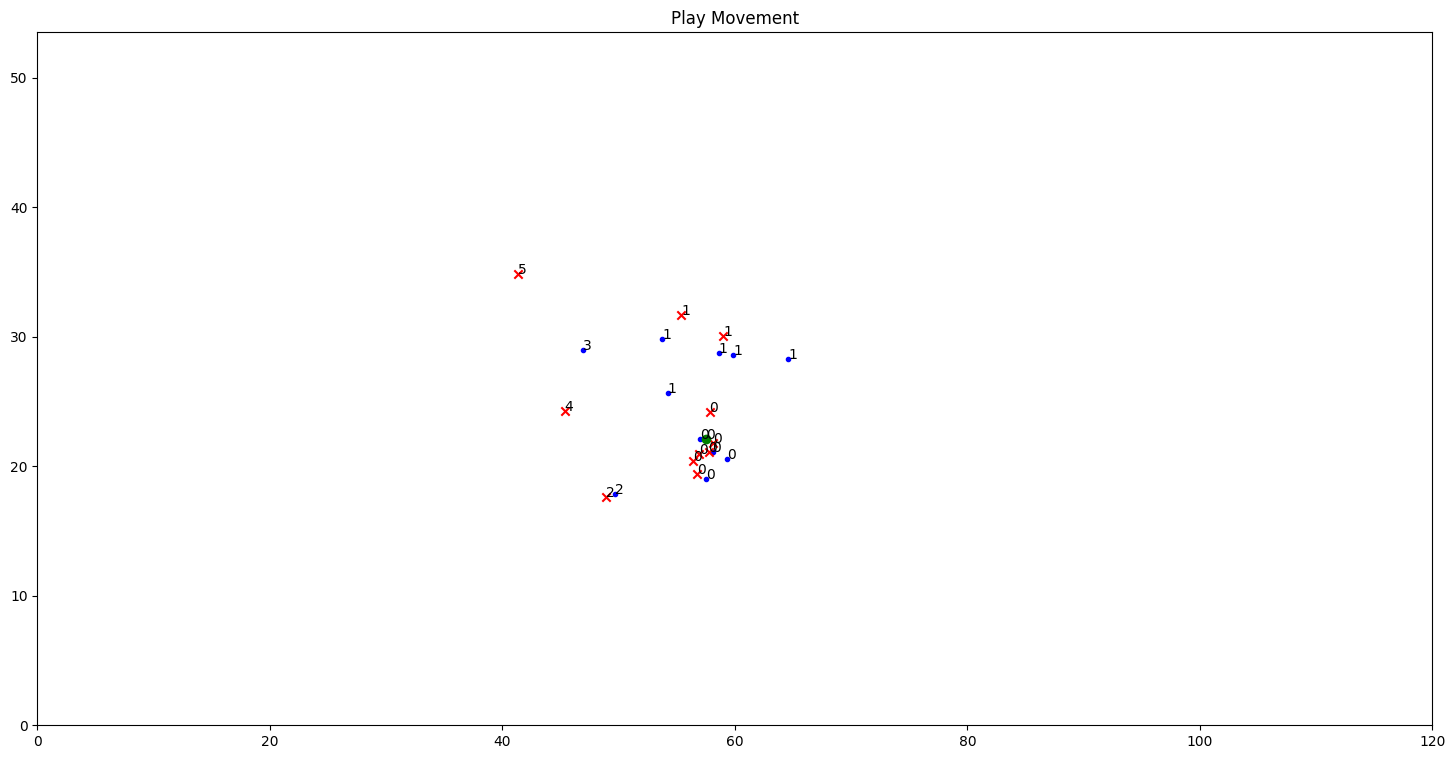

In [7]:
game_week1_df = tracking_week_1_df[tracking_week_1_df['gameId'] == 2022090800]
play_df = game_week1_df[game_week1_df['playId'] == 146]
play_anim = animate_play(play_df, plays_df, tackles_df);

In [8]:
cluster_stats = ball_cluster_concentration(play_df, plays_df)

In [9]:
cleaned_df = pd.read_csv(r'/kaggle/input/all-data-filtered/all_data_filtered.csv')

In [10]:
cols_to_remove1 = [cleaned_df.columns[i] for i in range(len(cleaned_df.columns)) if 'possessionTeam' in cleaned_df.columns[i]]
cols_to_remove2 = [cleaned_df.columns[i] for i in range(len(cleaned_df.columns)) if 'defensiveTeam' in cleaned_df.columns[i]]
cols_to_remove3 = ['weightDelta', 'quarter', 'yardsToGo', 'down']

In [11]:
y = pd.DataFrame(cleaned_df['tackle'])

In [12]:
X = cleaned_df.drop(['tackle', 'ballCarrierId'], axis = 1).fillna(0)
X = X.drop(cols_to_remove1, axis = 1).fillna(0)
X = X.drop(cols_to_remove2, axis = 1).fillna(0)
X = X.drop(cols_to_remove3, axis = 1).fillna(0)

In [13]:
merged_ball_cluster_df = pd.DataFrame()

In [14]:
for root,dirs,files in os.walk(r'/kaggle/input/ballclusterdata/'):
    for file in files:

        x = pd.read_csv(r'/kaggle/input/ballclusterdata/' + file)
        merged_ball_cluster_df = pd.concat([merged_ball_cluster_df, x])

In [15]:
merged_tackle_cluster_df = pd.DataFrame()

In [16]:
for root,dirs,files in os.walk(r'/kaggle/input/tackleclusterdata/'):
    for file in files:

        x = pd.read_csv(r'/kaggle/input/tackleclusterdata/' + file)
        merged_tackle_cluster_df = pd.concat([merged_tackle_cluster_df, x])

In [17]:
metrics_features_df = pd.DataFrame()

In [18]:
for root,dirs,files in os.walk(r'/kaggle/input/othermetricdata/'):
    for file in files:

        x = pd.read_csv(r'/kaggle/input/othermetricdata/' + file)
        metrics_features_df = pd.concat([metrics_features_df, x])

In [19]:
combined_df = plays_df.merge(right = merged_ball_cluster_df, how = 'left', on = ['gameId', 'playId'])
combined_df = combined_df.merge(right = merged_tackle_cluster_df, how = 'left', on = ['gameId', 'playId'])
combined_df = combined_df.merge(right = metrics_features_df, how = 'left', on = ['gameId', 'playId'])
combined_df = combined_df.merge(right = tackles_df, how = 'left', on = ['gameId', 'playId'])

In [20]:
formations = combined_df['offenseFormation'].dropna().unique()

# **Introduction**

When the word 'football' is mentioned, the next words that comes to mind is 'tackling'. Tackling is one of the most frightening yet awe-inspiring aspects of the game, and a well timed tackle can determine success for a team. Our aim in the following analysis is to identify in which situations a tackle is most likely to occur, the circumstances that led to that situation, and how the information can be used from a coaching perspective to realize a greater chance of success.

**Note - please run all cells in the 'Appendix/Code' section prior to running the cells in the rest of the notebook**

# **Methodology**

The data provided is already in a clean, tabular format and we can immediately begin with the analysis. Before diving into the model creation, I performed the following:


*   Engineered new features to be used as input variables
*   One-hot encoded all categorical columns   
*   Performed an OLS regression solely to gain insight in which features held significance (not for predictive purposes)
*   Removed input variables that either held no statistical significance, had too small of a sample size, or would create noise
*   Partitioned the data by offensive formation
*   Created an XG Boost model, a Neural Network, a Random Forest Regression, and an SVM model for each formation
*   Tuned the hyperparameters for each of the above models for each formation to optimize accuracy
*   Chose the model with the highest evaluation metrics, and related the engineered features to the most predictable situation to draw insight


# **Feature Engineering**

A common mistake made is to use input variables that are only available after a play has completed for predictive purposes. Using post-play data for play-related predictions is like saying an umbrella can predict rain, which is why I separated the engineered features into pre-snap and post-play categories.

Pre-Snap Features:
*   Offensive Line Total Weight
*   Devensive Line Total Weight
*   Line Weight Delta

Post-Play Features:
*   Snap-to-Tackle Time
*   Average Speed of Tackler
*   Average Acceleration of Tackler
*   Cluster Concentration of Ball and Tackler

Explain of the 'Cluster Concentration' metrics:

At a given time, we can calculate the distance to the ball for each player and then assign each player to a cluster based off of their distance to the ball. These cluster assignments can change from frame to frame, and we examine the concentration of offensive and defensive players in a cluster around the ball for each frame of a given play.

In the below animation of playId 146 and gameId 2022090800, the green dot represents the ball, the blue circles represent each player on the offensive line, and the red X's represent each player on the defensive line. Each player is annotated with their respective cluster, and we can see as we get closer to a tackle that the concentration of players in the same cluster as the ball increases:













In [21]:
play_anim

For each play of each game, I have calculated the following:

*   Offense Cluster Ratio - count of offensive players in the ball's cluster divided by total number of players in the ball's cluster
*   Defense Cluster Ratio - count of defensive players in the ball's cluster divided by total number of players in the ball's cluster
*   Offense Total Ratio - count of offensive players in the ball's cluster divided by total number of players on the field
*   Defense Total Ratio - count of defensive players in the ball's cluster divided by total number of players on the field

Additionally, I have calculated the total number of players in the cluster and divided by the total number of players on the field. For completeness' sake, I have done the same calculations for the cluster around the tackler.

To create a single metric for each play, I have taken the area under the curve for each of the ratios.

Below, we can visually see four of the ratios over time for a given play, with the red line indicating when the tackle occurred:

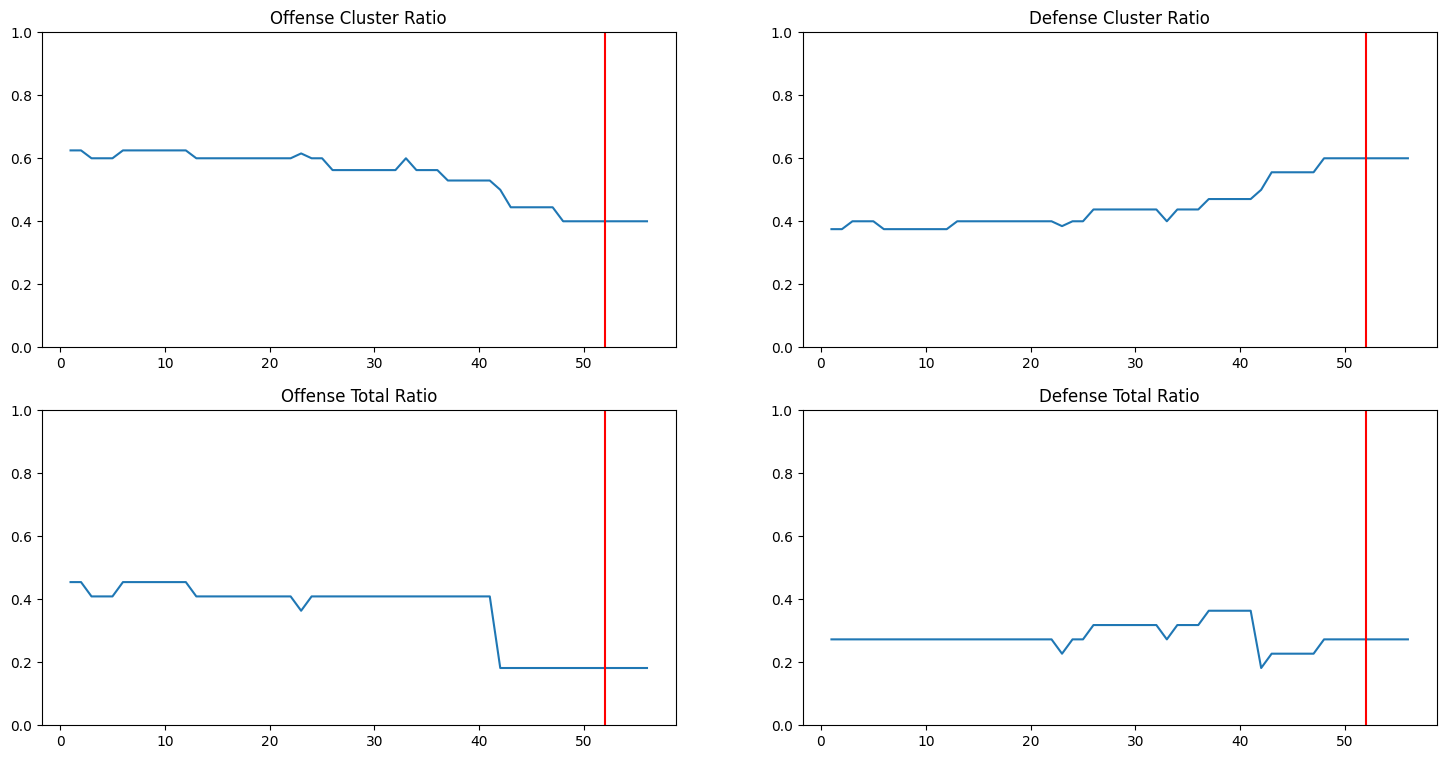

In [22]:
show_ball_cluster_graphs(cluster_stats)

# **OLS Regression**

Now, we perform the preliminary OLS regressions to gain intuition on which pre-snap variables will hold importance. The below table is ordered by decreasing levels of significance.

In [23]:
regress_off_all_formation(X, y, train_size = 0.80)

,variable,coef,p_vals,t_vals
4,passProbability,0.131385,4.162500e-11,6.603453
3,defendersInTheBox,-0.019067,1.606461e-04,-3.775040
5,preSnapHomeTeamWinProbability,0.430258,7.330735e-03,2.681828
1,preSnapVisitorScore,0.002405,1.088376e-02,2.546751
6,preSnapVisitorTeamWinProbability,0.379721,1.800951e-02,2.365703
0,preSnapHomeScore,-0.002012,2.574962e-02,-2.230206
9,expectedPoints,-0.005473,4.484980e-02,-2.006241
12,defenseWeight,0.000094,1.538622e-01,1.426099
10,expectedPointsAdded,-0.003933,2.974756e-01,-1.041901
2,absoluteYardlineNumber,-0.000120,4.979222e-01,-0.677780


We can see above that, from the engineered features, that 'defenseWeight' and 'offenseWeight' carry significance, albeit less significance than the features provided to us in the dataset.

# **Model Creation and Hyperparameter Tuning**

Initially, when creating models, the results were uninspiring. However, after partitioning by 'offenseFormation' the results began to look more promising. Intuitively, each formation is intended to have its own purpose and it makes sense that what works in predicting a tackle with one formation does not apply to another.

We created a four models (XGB, NN, RF, and SVM) for each offensive formation, and optimized the hyperparameters based on the accuracy of the predictions on the test set.

The results are as follows:

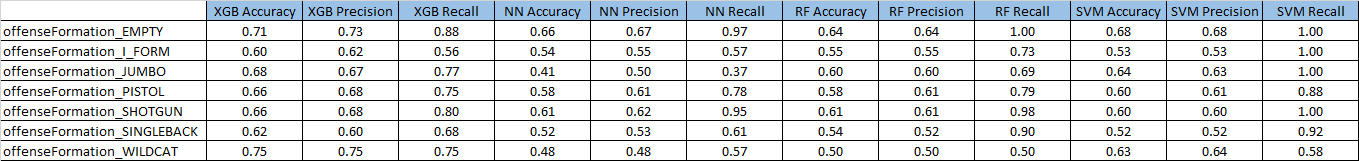

We can see from the above table that running an XG Boost model on the 'WILDCAT' offense formation yields the greatest results.

Now, we have found which offensive formation is the most predictable and can examine the characteristics to determine valuable insights for coaching.



# **Insights**



With a predictable formation, we will examine the frequency of occurrence of the post-play metrics developed earlier. The idea being, if we know the most likely outcome for the situation, that we can plan accordingly.

For example, examining the stap-to-tackle time for the Wildcat formation (the histogram on the right shows only plays where a tackle ocurred):

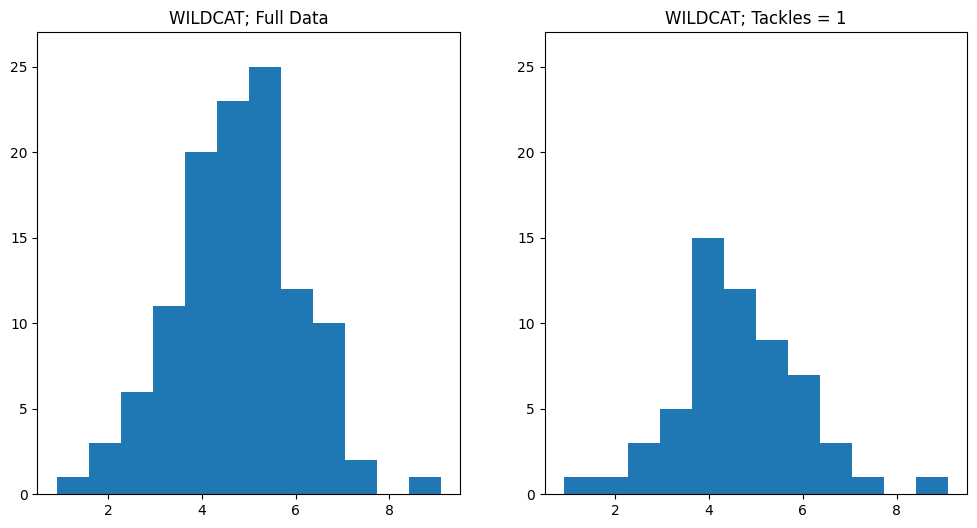

In [24]:
plot_hist_columns('sttTime', combined_df, 'WILDCAT', bins = 12, show_no_tackles = False)

We can see from the above that, when a tackle occurs, on average it takes about four seconds. From a coaching perspective, this means that we know a QB only has, on average, under four seconds to throw the ball.

For most formations, the above results are similar. Interestingly, the Shotgun formation yields different results:

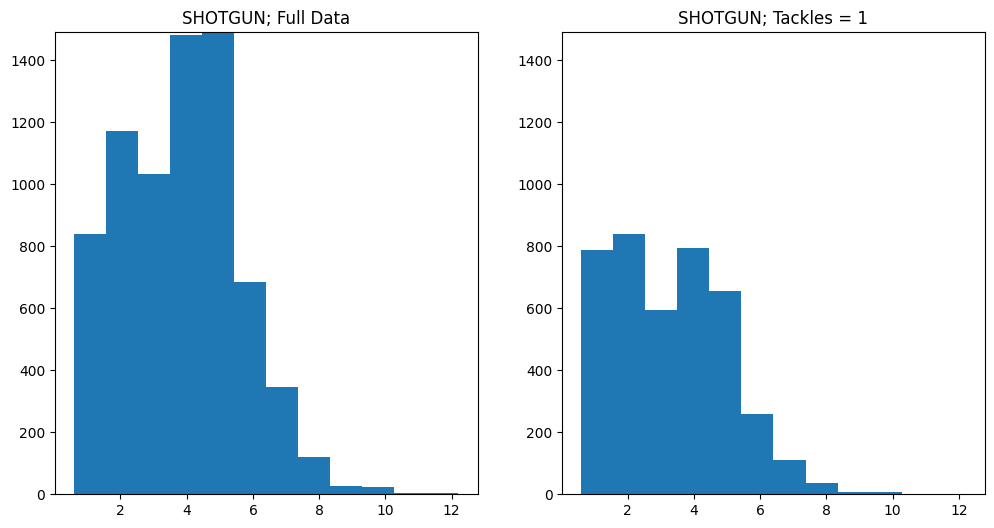

In [25]:
plot_hist_columns(column_name = 'sttTime', combined_df = combined_df, formation = 'SHOTGUN', bins = 12)

We can see that in the Shotgun formation the snap-to-tackle time is considerably less and the QB will need to throw even sooner.

The histogram for the 'weightDelta' column (the difference between total weight on the offensive side and the defensive side) showed the following results:

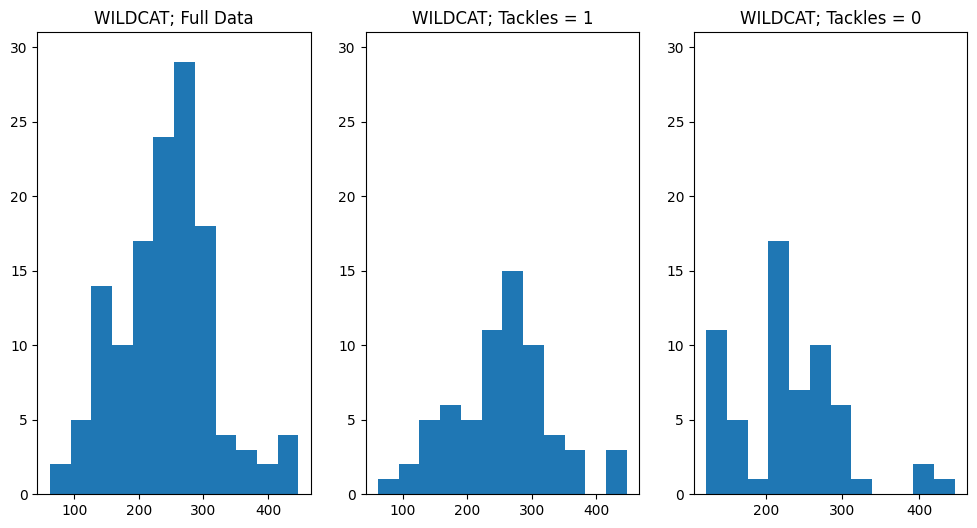

In [26]:
plot_hist_columns('weightDelta', combined_df, 'WILDCAT', bins = 12, show_no_tackles = True)

Again, we can draw an inference from the above. For the Wildcat formation we can say that it is more likely for a tackle to occur when the combined weight of the offensive line is about 300 pounds heavier than the defensive line, and a tackle is less likely to occur when the difference is closer to 200 pounds.

Another interesting histogram is that of the 'ballTotalAuc' metric, which calculates the area under the curve of the ratio of the total number of players in a cluster around the ball to the total number of players on the field.

Mathematically represented as:

$\int_{frame_{0}}^{frame_{n}} \frac{\sum Players In Cluster_i}{\sum Total Players_i}
$

Where 'n' is the number of frames in a given play, and $i \epsilon [0, n]$.

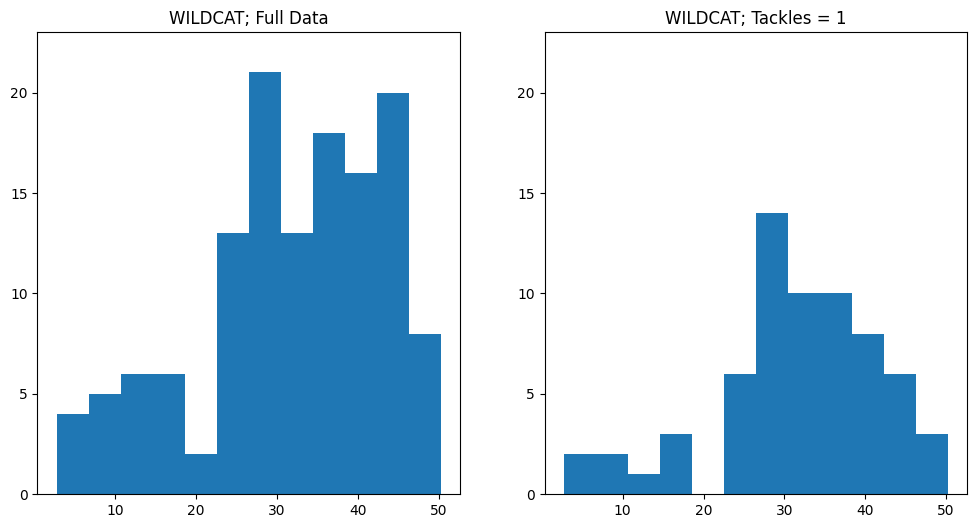

In [27]:
plot_hist_columns('ballTotalAuc', combined_df, 'WILDCAT', bins = 12, show_no_tackles = False)

We can see that the area under the curve is either small or large, with no occurrences of any in between. We can interpret the above chart as: either a tackle occurs from a single outside player, or from a large group of players at once.

# **Next Steps**

Although the results for the cluster metrics in the analysis were mostly inconclusive, I do believe that there is great potential to acquire valuable insights from such metrics. In many cases, the sample size of data for a given formation was relatively small, and as the sample size increases then the trends will be more evident.

Additionally, there are opportunities to examine a larger timeframe of data to find macro-level insights as well. For example, with Tom Brady retired most see the Chiefs as the team to beat, and with a new standard the strategies will adapt. Finding both macro-level and play-level trends are fascinating, and I am excited to continue the research   